# Introduction
This colab worksheet provides a starting point for the computer vision assignment. 

# Data Loading

In [ ]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.
!wget "https://sussex.box.com/shared/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz" -O training_images.npz
#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
# The test images (without points)
!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
# The example images are here
!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz
import numpy as np

# Load the data using np.load
training_data = np.load('training_images.npz', allow_pickle=True)
testing_data = np.load('test_images.npz', allow_pickle=True)
example_data = np.load('examples.npz')
# Extract the images
training_images = training_data['images']
testing_images = testing_data['images']
example_images = example_data['images']
# and the data points
pts = training_data['points']

--2021-05-11 13:10:10--  https://sussex.box.com/shared/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz
Resolving sussex.box.com (sussex.box.com)... 107.152.24.197
Connecting to sussex.box.com (sussex.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz [following]
--2021-05-11 13:10:10--  https://sussex.box.com/public/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz [following]
--2021-05-11 13:10:10--  https://sussex.app.box.com/public/static/cbvuazevif0oczabom06zl2x7ukakbqj.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 107.152.24.201
Connecting to sussex.app.box.com (sussex.app.box.com)|107.152.24.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

# Useful packages

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

import cv2

import numpy as np
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import random

In [ ]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit since some none-free features are not avilable
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

  Using cached https://files.pythonhosted.org/packages/12/32/8d32d40cd35e61c80cb112ef5e8dbdcfbb06124f36a765df98517a12e753/opencv_contrib_python-3.4.2.17-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/a5/42/560d269f604d3e186a57c21a363e77e199358d054884e61b73e405dd217c/numpy-1.20.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.20.3
    Uninstalli

# Data Visualisation
Here's an example of how to display the images and their points

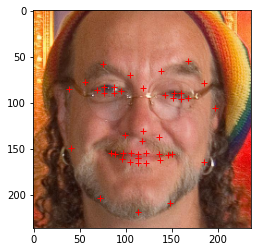

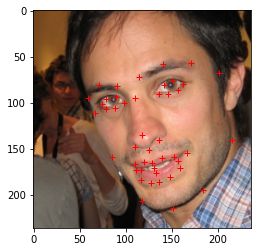

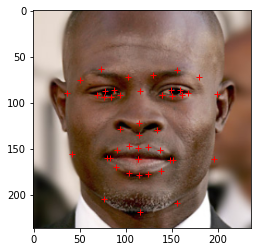

In [ ]:
def visualise_pts(img, pts,back=None,colour='r+',save = False,name = None):
  plt.imshow(img,back)
  plt.plot(pts[:, 0], pts[:, 1], colour)
  if save:
    ##plt.title(name)
    plt.axis('off')
    ##name = name +'.png'
    plt.savefig(name)
    files.download(name)
  plt.show()

for i in range(3):
  idx = np.random.randint(0, training_images.shape[0])
  visualise_pts(training_images[idx, ...], pts[idx, ...])

# Calculating Prediction Error and exporting results

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [ ]:
def save_as_csv(points, location = '.'):
  """
  Save the points out as a .csv file
  :param points: numpy array of shape (no_image, no_points, 2) to be saved
  :param location: Directory to save results.csv in. Default to current working directory
  """
  np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


# Pre processing the training data
In this stage we will be focusing on reducing the dimensionality of the training data, and normalising the images

Original resolution images  (2811, 236, 236, 3)
Lower resolution images images  (2811, 118, 118, 3)


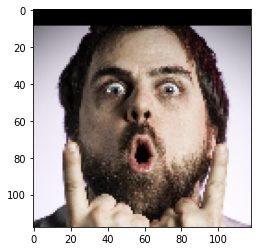

In [ ]:
##Lowering the resolution of training and testing images, and training face shapes
training_images_low_res = []
face_shapes = []

for single_train_image in training_images:
  training_images_low_res.append(single_train_image[::2,::2,:]) #Half the pixels across each image

for pts_small in pts:
  face_shapes.append(pts_small/2)     #Half the size of the landmarks to fit in the image

training_images_low_res = np.asarray(training_images_low_res)
face_shapes = np.asarray(face_shapes)

''''''''''''''''''''''''
''''''''''''''''''''''''
''''''''''''''''''''''''

print("Original resolution images ",training_images.shape)
print("Lower resolution images images ",training_images_low_res.shape)
plt.imshow(example_images[3,::2,::2,:])

(2811, 118, 118, 3)


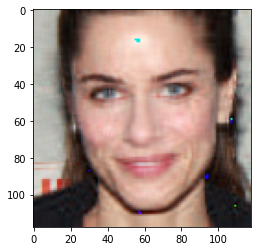

In [ ]:
##Compress the images by using PCA to remove features
normalised_training_images = []
for img in training_images_low_res:
  blue,green,red = cv2.split(img)   ##split RGB dimensions

  pca = PCA(20)
 
  red_transformed = pca.fit_transform(red)  ##Inverse transform to keep low resolution image sizes for red, green and blue dimensions
  red_inverted = pca.inverse_transform(red_transformed)
 
  green_transformed = pca.fit_transform(green)
  green_inverted = pca.inverse_transform(green_transformed)
 
  blue_transformed = pca.fit_transform(blue)
  blue_inverted = pca.inverse_transform(blue_transformed)

  normalised_training_images.append((np.dstack((blue_inverted, green_inverted, red_inverted))).astype(np.uint8))  #Recombine RGB dimensions for each image


normalised_training_images = np.asarray(normalised_training_images)

''''''''''''''''''''''''
''''''''''''''''''''''''
''''''''''''''''''''''''
print(normalised_training_images.shape)
plt.imshow(normalised_training_images[0])

RGB training images  (2811, 236, 236, 3)
Grayscale training images  (2811, 118, 118)


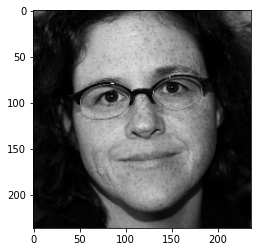

In [ ]:
##Converting all training images to grayscale
training_img_gray = []

for single_train_image_low_res in normalised_training_images:
  training_img_gray.append(np.uint8(np.mean(single_train_image_low_res, axis=-1))) #Convert images to grey scale
training_img_gray = np.asarray(training_img_gray)

''''''''''''''''''''''''
''''''''''''''''''''''''
''''''''''''''''''''''''

print("RGB training images ",training_images.shape)
print("Grayscale training images ",training_img_gray.shape)
plt.imshow(np.uint8(np.mean(example_images[5,...], axis=-1)),cmap='gray')

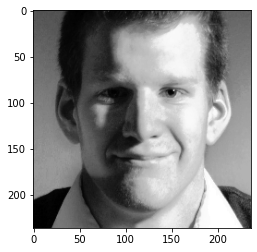

In [ ]:
##Perform grayscale equalisation on the training images
training_img_eq = []
for single_train_img_gray in training_img_gray:
  training_img_eq.append(cv2.equalizeHist(single_train_img_gray)) #Equalise gray histogram
training_img_eq = np.asarray(training_img_eq)

''''''''''''''''''''''''
''''''''''''''''''''''''
''''''''''''''''''''''''
plt.imshow(cv2.equalizeHist(np.uint8(np.mean(example_images[0,...], axis=-1))),cmap='gray')

# Cascaded regression
Now that we have finished the pre-processing stage, we will perform face alignment via cascaded regression

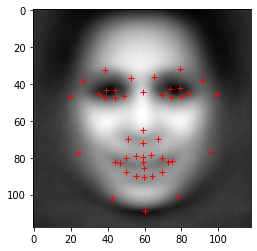

In [ ]:
##Firstly, calculate the average face shape of all the training images, in order to set a starting point for the cascaded regression algorithm
point_x = np.asarray([np.average(face_shapes[:,i,0])for i in range(face_shapes.shape[1])])  #Take average of each point of each image in the y coordinate
point_y = np.asarray([np.average(face_shapes[:,i,1])for i in range(face_shapes.shape[1])])  #Take average of each point of each image in the x coordinate
avg_face_shape = np.concatenate([point_x[:,None],point_y[:,None]], axis=1)  #Combine both np arrays to create average face shape

''''''''''''''''''''''''
''''''''''''''''''''''''
''''''''''''''''''''''''

all_img = np.array([np.array(tr_img) for tr_img in training_images_low_res])
avg_image = np.average(all_img,axis=0)
avg_image = np.uint8(np.mean(avg_image, axis=-1))
visualise_pts(Image.fromarray(avg_image.astype('uint8')),avg_face_shape,'gray')

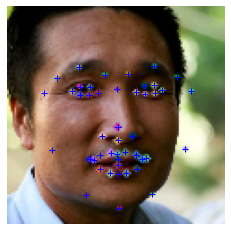

In [ ]:
##We must first create a function, in order to extract keypoints from an image
def feature_extractor(face_shape,spatial_scale=1):
  keypoints = []
  for i in range(46):
    x_coord = face_shape[i,0]
    y_coord = face_shape[i,1]

    ##Keypoints around face
    if i<14:
      keypoints.append(cv2.KeyPoint(x_coord,y_coord,spatial_scale))
    ##Keypoints around nose
    elif i>=14 and i<18:
      keypoints.append(cv2.KeyPoint(x_coord,y_coord,3))
    ##Keypoints around mouth
    elif i>=30:
      keypoints.append(cv2.KeyPoint(x_coord,y_coord,3))
    ##Keypoints around eyes
    else:
      keypoints.append(cv2.KeyPoint(x_coord,y_coord,2))

    

  return keypoints

''''''''''''''''''''''''
''''''''''''''''''''''''
''''''''''''''''''''''''

# This function will draw the keypoints on the images, showing their orientation
def draw_im_kps(img, kps,face_shape):
  assert(img.shape[-1] == 3)
  img_kp = np.zeros_like(img)
  cv2.drawKeypoints(img, kps, img_kp, flags=4)
  plt.imshow(img_kp)
  plt.plot(face_shape[:,0],face_shape[:,1],'b+')
  plt.axis('off')
  ##plt.savefig('ext.png')
  ##files.download('ext.png')
  plt.show()

draw_im_kps(example_images[4,::2,::2], feature_extractor(avg_face_shape),avg_face_shape)

In [ ]:
##Regressor class, trained by cascaded regression
class Regressor:
  def __init__(self,avg_face_shape):
    self.avg_face_shape = avg_face_shape  ##When creating instance of Regressor, pass the average face shape
  
  def train(self,train_images,gt_shapes,iterations):
    sift = cv2.xfeatures2d.SIFT_create()  ##Create a SIFT object

    shapes = []   ##Initialise empty array for predicted shapes
    regressors = []   #Trained regressors will be appended to the list after every iteration
    shapes.append(avg_face_shape) ##Empty array will start with average face shape for every image passed into the training method
    for i in range(iterations): 
      descriptors  = [] ##Create a descriptor list to append the features extracted from each image
      target = [] #Empty array for target, which is the distance between the previous predicted points and the ground truth points
      if i>=1:
        shapes = [] #If it is the second iteration re create shapes list
      for j in range(train_images.shape[0]):  #For each image passed in the training method
        if i>=1:  #If it is the second iteration or more of the cascaded regression
          shapes.append(self.cascade_test(train_images[j],regressors))   #Predict points given the points predicted in the previous iteration
          descriptors.append(sift.compute(train_images[j].astype('uint8'),feature_extractor(shapes[j]))[1]) #Extract features from predicted points
          target.append((gt_shapes[j]-shapes[j])) #Append target
        else:
          descriptors.append(sift.compute(train_images[j].astype('uint8'),feature_extractor(shapes[i]))[1]) #If its the first iteration, calculate the SIFT features in the average face shape
          target.append((gt_shapes[j]-shapes[i])) #Append target
        
      descriptors = np.array([des.flatten() for des in descriptors])  #Flatten the descriptors and target arrays, to prevent colab from crashing
      target = np.array([t.flatten() for t in target])
      
      model = linear_model.Lasso()  #Create Least Absolute Shrinkage and Selection Operator regression model from sklearn
      regressors.append(model.fit(descriptors,target))  #Fit the features as X and target as y
    
    return regressors

  def cascade_test(self,input_image,regressors):  ##Similar to the testing method, except we don't do any pre processing on the images, as only the training images go pass this method, and training images have already been pre processed
    sift = cv2.xfeatures2d.SIFT_create()

    shapes = []
    shapes.append(avg_face_shape)
    for k in range(len(regressors)):
      descriptors = sift.compute(input_image.astype('uint8'),feature_extractor(shapes[k]))[1]
      prediction = (regressors[k].predict(descriptors.reshape(-1,5888)))
      movement = (shapes[k]+prediction.reshape(-1,2))
      shapes.append(movement)
    return movement 

  def test(self,input_image,regressors):
    sift = cv2.xfeatures2d.SIFT_create()  #Create SIFT object
    input_image = input_image[::2,::2,:]  #Half resolution of testing image


    shapes = [] #Create empty array for predicted shape after each regressor iteration
    shapes.append(avg_face_shape) #Start with average face shape

    for k in range(len(regressors)):  #For each trained regressor
      descriptors = sift.compute(input_image.astype('uint8'),feature_extractor(shapes[k]))[1] ##Get the features from the landmarks in the current face shape
      prediction = (regressors[k].predict(descriptors.reshape(-1,5888)))  #Reshape the features, in order to be able to pass in the regressor prediction model
      movement = (shapes[k]+prediction.reshape(-1,2)) #Reshape the predicted points and sum/substract them from the current predicted shape
      shapes.append(movement) #Append last predicted shape
    return movement*2 #Multiply final result by 2 in order to fit the face in the image properly


# Cross Validation

In [ ]:
##Firstly shuffle all of the training images with their respected face shapes
training_images_indexes = []
for index in range(training_images_low_res.shape[0]):
  training_images_indexes.append(index)

random.shuffle(training_images_indexes)

fold_1_images = []
fold_1_shapes = []

fold_2_images = []
fold_2_shapes = []

fold_3_images = []
fold_3_shapes = []

for j in range(len(training_images_indexes)):
  if j<937:
    fold_1_images.append(training_images_low_res[training_images_indexes[j]])
    fold_1_shapes.append(face_shapes[training_images_indexes[j]])
  elif j>=937 and j<1874:
    fold_2_images.append(training_images_low_res[training_images_indexes[j]])
    fold_2_shapes.append(face_shapes[training_images_indexes[j]])
  else:
    fold_3_images.append(training_images_low_res[training_images_indexes[j]])
    fold_3_shapes.append(face_shapes[training_images_indexes[j]])

In [ ]:
##Create 3 new training and testing sets
###########################################1st k-fold#############################################
k_training_img_1 = []
k_training_shapes_1 = []
validation_set_images_1 = []
validation_set_shapes_1 = []

for f1 in range(len(fold_1_images)):
  k_training_img_1.append(fold_1_images[f1])
  k_training_shapes_1.append(fold_1_shapes[f1])

  validation_set_images_1.append(fold_3_images[f1])
  validation_set_shapes_1.append(fold_3_shapes[f1])

for f2 in range(len(fold_2_images)):
  k_training_img_1.append(fold_2_images[f2])
  k_training_shapes_1.append(fold_2_shapes[f2])

k_training_img_1 = np.asarray(k_training_img_1)
k_training_shapes_1 = np.asarray(k_training_shapes_1)
validation_set_images_1 = np.asarray(validation_set_images_1)
validation_set_shapes_1 = np.asarray(validation_set_shapes_1)

regressor_1 = Regressor(avg_face_shape)
trained_reg_1 = regressor_1.train(k_training_img_1,k_training_shapes_1,10)

results_1 = []
error_rate_1 = 0
for val_img_1 in validation_set_images_1:
  results_1.append(regressor_1.cascade_test(val_img_1,trained_reg_1))
for a in range(len(validation_set_shapes_1)):
  error_rate_1 += abs(np.average(euclid_dist(results_1[a],validation_set_shapes_1[a])))

###########################################2nd k-fold#############################################
k_training_img_2 = []
k_training_shapes_2 = []
validation_set_images_2 = []
validation_set_shapes_2 = []

for f1 in range(len(fold_1_images)):
  k_training_img_2.append(fold_1_images[f1])
  k_training_shapes_2.append(fold_1_shapes[f1])

  validation_set_images_2.append(fold_2_images[f1])
  validation_set_shapes_2.append(fold_2_shapes[f1])
  
for f3 in range(len(fold_3_images)):
  k_training_img_2.append(fold_3_images[f3])
  k_training_shapes_2.append(fold_3_shapes[f3])

k_training_img_2 = np.asarray(k_training_img_2)
k_training_shapes_2 = np.asarray(k_training_shapes_2)
validation_set_images_2 = np.asarray(validation_set_images_2)
validation_set_shapes_2 = np.asarray(validation_set_shapes_2)

regressor_2 = Regressor(avg_face_shape)
trained_reg_2 = regressor_2.train(k_training_img_2,k_training_shapes_2,10)

results_2 = []
error_rate_2 = 0
for val_img_2 in validation_set_images_2:
  results_2.append(regressor_2.cascade_test(val_img_2,trained_reg_2))
for b in range(len(validation_set_shapes_2)):
  error_rate_2 += abs(np.average(euclid_dist(results_2[b],validation_set_shapes_2[b])))
###########################################3rd k-fold#############################################
k_training_img_3 = []
k_training_shapes_3 = []
validation_set_images_3 = []
validation_set_shapes_3 = []

for f2 in range(len(fold_2_images)):
  k_training_img_3.append(fold_2_images[f2])
  k_training_shapes_3.append(fold_2_shapes[f2])

  validation_set_images_3.append(fold_1_images[f2])
  validation_set_shapes_3.append(fold_1_shapes[f2])
  
for f3 in range(len(fold_3_images)):
  k_training_img_3.append(fold_3_images[f3])
  k_training_shapes_3.append(fold_3_shapes[f3])

k_training_img_3 = np.asarray(k_training_img_3)
k_training_shapes_3 = np.asarray(k_training_shapes_3)
validation_set_images_3 = np.asarray(validation_set_images_3)
validation_set_shapes_3 = np.asarray(validation_set_shapes_3)

regressor_3 = Regressor(avg_face_shape)
trained_reg_3 = regressor_3.train(k_training_img_3,k_training_shapes_3,10)

results_3 = []
error_rate_3 = 0
for val_img_3 in validation_set_images_3:
  results_3.append(regressor_3.cascade_test(val_img_3,trained_reg_3))
for c in range(len(validation_set_shapes_3)):
  error_rate_3 += abs(np.average(euclid_dist(results_3[c],validation_set_shapes_3[c])))
###########################################Finish################################################
print("K-Fold 1 error rate ",error_rate_1/len(results_1))
print("K-Fold 2 error rate ",error_rate_2/len(results_2))
print("K-Fold 3 error rate ",error_rate_3/len(results_3))

K-Fold 1 error rate  2.2394553393107097
K-Fold 2 error rate  2.2477564424107115
K-Fold 3 error rate  2.19462122493834


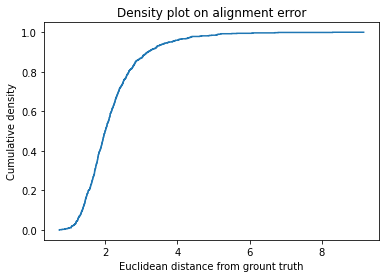

In [ ]:
cum_error = []
for c in range(len(validation_set_shapes_3)):
  cum_error.append(abs(np.average(euclid_dist(results_3[c],validation_set_shapes_3[c]))))

for e in [cum_error]:
  plt.step(np.sort(e),np.linspace(0,1,len(e)))
  plt.title("Density plot on alignment error")
  plt.ylabel("Cumulative density")
  plt.xlabel("Euclidean distance from grount truth")
  ##plt.savefig('cum.png')
  ##files.download('cum.png')

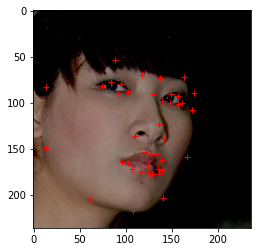

1.6498919829530028

In [ ]:
pred_shape = regressor_3.test(training_images[2809],trained_reg_3)
visualise_pts(training_images[2809],pred_shape)
np.average(euclid_dist(pred_shape,pts[2809]))

In [ ]:
sub = []
for test in testing_images:
  pred_shape = regressor_3.test(test,trained_reg_3)
  sub.append(pred_shape)

sub = np.asarray(sub)
print(sub.shape)



(554, 46, 2)


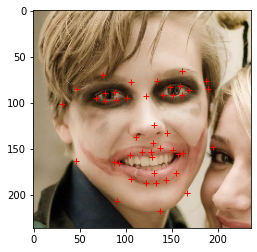

In [ ]:
pred_shape = regressor_3.test(testing_images[198],trained_reg_3)
visualise_pts(testing_images[198],pred_shape)

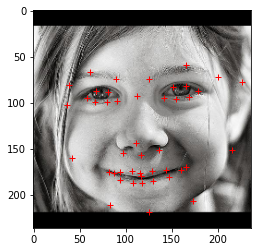

In [ ]:
pred_shape = regressor_3.test(testing_images[0],trained_reg_3)
visualise_pts(testing_images[0],pred_shape)

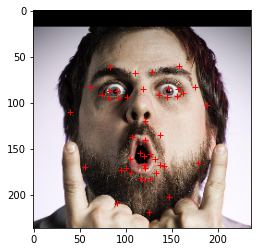

In [ ]:
pred_shape = regressor_3.test(testing_images[200],trained_reg_3)
visualise_pts(testing_images[200],pred_shape)

In [ ]:
save_as_csv(sub,"/content/gdrive/My Drive")

In [ ]:
import pandas as pd 
pd.DataFrame(np.reshape(sub, (sub.shape[0], -1))).to_csv("/content/gdrive/My Drive/my_results.csv")

# Face Segmentation

In [ ]:
from skimage.draw import line, polygon, circle, ellipse
import numpy as np

(-0.5, 235.5, 235.5, -0.5)

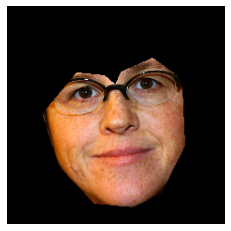

In [ ]:
def segment(image, shape,show_segmented = False):
  image_copy = np.copy(image)
  good_shape = []
  i = 0
  for pt in shape[:7]:
    good_shape.append(pt)

  good_shape.append(shape[12])
  good_shape.append(shape[11])
  good_shape.append(shape[10])
  good_shape.append(shape[13])
  good_shape.append(shape[9])
  good_shape.append(shape[8])
  good_shape = np.asarray(good_shape).reshape(-1,2)

  mask = np.zeros(image_copy.shape,dtype=np.uint8)
  cv2.fillPoly(mask,np.int32([[good_shape]]),(255,255,255))
  if show_segmented:
    masked = cv2.bitwise_and(image_copy, mask)
    return masked
  else:
    rr, cc = polygon(good_shape[:,1], good_shape[:,0], image_copy.shape)
    image_copy[rr,cc,2] = 200
    masked = cv2
    return image_copy


pred_shape = regressor_1.test(example_images[5],trained_reg_1)
plt.imshow(segment(example_images[5],pred_shape,True))
plt.axis('off')
##plt.savefig('s-seg.png')
##files.download('s-seg.png')

# Graphical effects

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
DRIVE_BASE = '/content/gdrive/My Drive'

Mounted at /content/gdrive


(-0.5, 235.5, 235.5, -0.5)

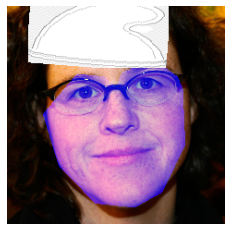

In [ ]:
def convertSmurf(image,shape):
  img = segment(image,shape)
  img = Image.fromarray(np.uint8(np.array(np.copy(img))))
  sides = round(shape[6,0])-round(shape[0,0])
  h = sides/2

  oppo = shape[11,0] - shape[0,0]
  adj = shape[11,1] - shape[0,1]
  angle = np.arctan(oppo/adj)*4

  x = round(shape[10,0]-sides/1.5)
  y = round(shape[10,1]-sides/1.9)

  
  smurf_hat = Image.open('/content/gdrive/MyDrive/smurf_hat.png').convert("RGBA")
  smurf_hat.putalpha(255)
  smurf_hat = smurf_hat.resize((sides,round(h)))
  smurf_hat = smurf_hat.rotate(angle)

  img.paste(smurf_hat,[x,y],mask=smurf_hat.split()[3])

  return img
  
pred_shape = regressor_1.test(example_images[5],trained_reg_1)
plt.imshow(convertSmurf(example_images[5],pred_shape))
plt.axis('off')
##plt.savefig('six-smurf.png')
##files.download('six-smurf.png')

# Qualitative and Quantitive results

Qualitative illustration of cascaded regression face alignment

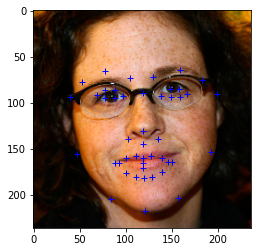

In [ ]:
##Initial face shape, S0, average face shape
visualise_pts(example_images[5],avg_face_shape*2,colour='+b',save = False,name = 'S0')

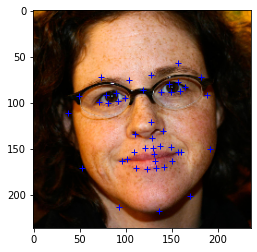

In [ ]:
##Face shape after 1 iterations
regressor_S1 = Regressor(avg_face_shape)
trained_regressors_S1 = regressor_S1.train(training_img_eq,face_shapes,1)
visualise_pts(example_images[5],regressor_S1.test(example_images[5],trained_regressors_S1),colour='+b',save = False,name = 'S1')

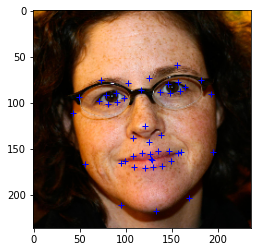

In [ ]:
##Face shape after 4 iterations
regressor_S4 = Regressor(avg_face_shape)
trained_regressors_S4 = regressor_S4.train(training_img_eq,face_shapes,4)
visualise_pts(example_images[5],regressor_S4.test(example_images[5],trained_regressors_S4),colour='+b',save = False,name = 'S4')

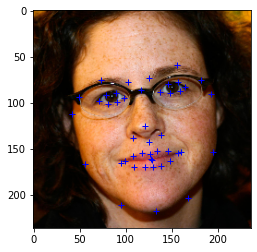

In [ ]:
##Face shape after 10 iterations
regressor_S10 = Regressor(avg_face_shape)
trained_regressors_S10 = regressor_S10.train(training_img_eq,face_shapes,10)
visualise_pts(example_images[5],regressor_S10.test(example_images[5],trained_regressors_S10),colour='+b',save = False,name = 'S10')

(-0.5, 117.5, 117.5, -0.5)

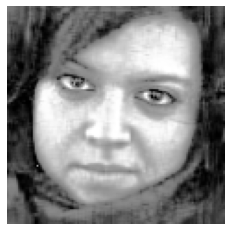

In [ ]:
low_feat_img = np.copy(example_images[1,::2,::2])
blue,green,red = cv2.split(low_feat_img)

pca = PCA(20)
 
red_transformed = pca.fit_transform(red)
red_inverted = pca.inverse_transform(red_transformed)
 
green_transformed = pca.fit_transform(green)
green_inverted = pca.inverse_transform(green_transformed)
 
blue_transformed = pca.fit_transform(blue)
blue_inverted = pca.inverse_transform(blue_transformed)

low_feat_img = (np.dstack((blue_inverted, green_inverted, red_inverted))).astype(np.uint8)
low_feat_img = cv2.equalizeHist(np.uint8(np.mean(low_feat_img, axis=-1)))
plt.imshow(low_feat_img,cmap='gray')
plt.axis('off')
#plt.savefig('low_feat.png')
#files.download('low_feat.png')

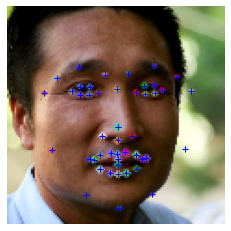

In [ ]:
draw_im_kps(example_images[4,::2,::2], feature_extractor(avg_face_shape),avg_face_shape)

# Comparing different pre processing techniques

In [ ]:
#########################################Low resolution images#################################################
X_train, X_test, y_train, y_test = train_test_split(training_images_low_res, face_shapes, test_size=0.33, random_state=42)

regressor_low_res = Regressor(avg_face_shape)
trained_regressors = regressor_low_res.train(X_train,y_train,10)

results_low_res = []
error_rate_low_res = 0
for val_img in X_test:
  results_low_res.append(regressor_low_res.cascade_test(val_img,trained_regressors))
for i in range(len(y_test)):
  error_rate_low_res += abs(np.average(euclid_dist(results_low_res[i],y_test[i])))

error_rate_low_res/=len(results_low_res)

In [ ]:
#########################################PCA images#################################################
X_train, X_test, y_train, y_test = train_test_split(normalised_training_images, face_shapes, test_size=0.33, random_state=42)

regressor_norm = Regressor(avg_face_shape)
trained_regressors = regressor_low_res.train(X_train,y_train,10)

results_norm = []
error_rate_norm = 0
for val_img in X_test:
  results_norm.append(regressor_norm.cascade_test(val_img,trained_regressors))
for i in range(len(y_test)):
  error_rate_norm += abs(np.average(euclid_dist(results_norm[i],y_test[i])))

error_rate_norm/=len(results_norm)

In [ ]:
#########################################Gray images#################################################
X_train, X_test, y_train, y_test = train_test_split(training_img_gray, face_shapes, test_size=0.33, random_state=42)

regressor_gray = Regressor(avg_face_shape)
trained_regressors = regressor_gray.train(X_train,y_train,10)

results_gray= []
error_rate_gray = 0
for val_img in X_test:
  results_gray.append(regressor_gray.cascade_test(val_img,trained_regressors))
for i in range(len(y_test)):
  error_rate_gray += abs(np.average(euclid_dist(results_gray[i],y_test[i])))

error_rate_gray/=len(results_gray)

In [ ]:
#########################################Equalised images#################################################
X_train, X_test, y_train, y_test = train_test_split(training_img_eq, face_shapes, test_size=0.33, random_state=42)

regressor_eq = Regressor(avg_face_shape)
trained_regressors = regressor_eq.train(X_train,y_train,10)

results_eq = []
error_rate_eq = 0
for val_img in X_test:
  results_eq.append(regressor_eq.cascade_test(val_img,trained_regressors))
for i in range(len(y_test)):
  error_rate_eq += abs(np.average(euclid_dist(results_eq[i],y_test[i])))

error_rate_eq/=len(results_eq)
###########################################################################################################

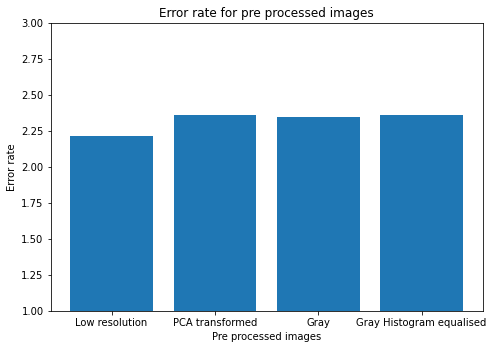

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
images_pro = ['Low resolution', 'PCA transformed', 'Gray', 'Gray Histogram equalised']
errors = [error_rate_low_res,error_rate_norm,error_rate_gray,error_rate_eq]
ax.bar(images_pro,errors)
plt.ylabel('Error rate')
plt.xlabel('Pre processed images')
plt.title('Error rate for pre processed images')
plt.ylim(1, 3)
##plt.savefig('error.png',bbox_inches='tight')
##files.download('error.png')
plt.show()

2.106128869252768


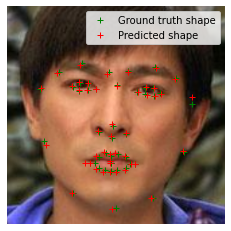

In [ ]:
##Qualitative comparison between ground truth and predicted shapes
predicted = regressor_low_res.test( [21],trained_regressors)
plt.imshow(training_images[21])
plt.plot(pts[21,:, 0], pts[21,:, 1], 'g+',label='Ground truth shape')
plt.plot(predicted[:, 0], predicted[:, 1], 'r+',label='Predicted shape')
print(np.average(euclid_dist(pts[21],predicted)))
plt.legend()
plt.axis('off')
##plt.savefig('show.png',bbox_inches='tight')
##files.download('show.png')
plt.show()